# 1.0 Becker Data Modelling XGBoost  
notebook: 1.1-becker-data-modelling-XGBoost

author: Jonathan Becker  

**Updated:** 2025-12-03
**Purpose:** Explore a stratified subset of the concatenated dataset using the preprocessing pipeline from 1.3.  
**Summary:** This notebook applies the preprocessing pipeline to the subset and performs dimensionality reduction with PCA and UMAP for exploratory analysis. The goal is to understand class separability and data structure before model training.


In [39]:
# imports 
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('../../library')
print(os.path.isfile('../../library/gc_storage.py'))
import gc_storage
from joblib import load,dump

from google.cloud import storage
# pipeline from 1.3-leibold-data-modelling_randomForest 
# visualization
import matplotlib.pyplot as plt
import seaborn as sns


# pipeline compatibel classes
from road_accidents_pipeline import RemoveIrrelevantCols         # removes some unnecessary columns
from road_accidents_pipeline import RearrangeCatCols             # bundle veh classes together to higher-tier classes
from road_accidents_pipeline import ConditionalMultiQuantImputer # impute missing values of quantiative variables via distr. on cat var
from road_accidents_pipeline import ConditionalCatImputer        # impute missing values of categorcial variables on target distribution
from road_accidents_pipeline import AggrLocaSplit                # aggregation of loca intersections incl. oneHotEncoding 
from road_accidents_pipeline import SupervisedEncoderWrapper     # wrapper for supervised encoders like CatBoostEncoder or TargetEncoder to make it work in pipeline
from road_accidents_pipeline import RemoveIdCols                 # removes ind_temp_id and acc_num after aggregation

# imputer
from sklearn.impute import SimpleImputer

# scaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# encoder
from sklearn.preprocessing import OneHotEncoder, SplineTransformer
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder, CatBoostEncoder
import category_encoders
from category_encoders.utils import BaseEncoder



# train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV 

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score

# pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# resampling
from imblearn.over_sampling import SMOTE

# model classifier
from xgboost import XGBClassifier

# little helper
from cleaning_utils import distinguish_cols, print_col_categories
import time

# PCA
from sklearn.decomposition import PCA
# UMAP
import umap 
# SHAP
import shap

True


In [40]:
# init Google Cloud storage
bucket_name='sep25-bds-road-accidents'
key_path='../../auth/fiery-glass-478009-t8-18a81c8cbe63.json'

bucket = gc_storage.init_bucket( bucket=bucket_name,
                                 json_key_path=key_path )
# listing joblibs
gc_storage.list_bucket( bucket=bucket,
                        remote_folder='2_preprocessing' )
# load concatenated dataframe from google cloud storage
df = gc_storage.download( bucket=bucket,
                                  remote_path='2_preprocessing/1.2-leibold-data-preprocessing_concat.joblib')

if 'ind_severity' not in df.columns:
    raise KeyError("Column 'ind_severity' not found in df")

Initialized sep25-bds-road-accidents
Number of blobs: [31]
data/processed/2_preprocessing/
data/processed/2_preprocessing/0.1-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.2-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.3-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.4-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/1.0-becker-data-preprocessing_usagers.joblib
data/processed/2_preprocessing/1.0-leibold-data-preprocessing_vehicles.joblib
data/processed/2_preprocessing/1.0-munz-acc-municipality_X_test_uniques_lookup_table.gc
data/processed/2_preprocessing/1.0-munz-acc-municipality_X_train_uniques_lookup_table.gc
data/processed/2_preprocessing/1.0-munz-preprocessing-X_test.gc
data/processed/2_preprocessing/1.0-munz-preprocessing-X_train_num.gc
data/processed/2_preprocessing/1.0-munz-preprocessing-y_test.gc
data/processed/2_preprocessing/1.0-munz-preprocessing-y_train.gc
data/process

In [41]:
# stratified sample with 500000 rows for PCA and modelling
df.shape

X = df.drop(columns=["ind_severity"])
y = df["ind_severity"]

# draw 400k rows with stratified sampling
X_sample, _, y_sample, _ = train_test_split(
    X, y,
    train_size=400000,
    stratify=y,
    random_state=42
)

df_sample = X_sample.copy()
df_sample["target"] = y_sample
print(df_sample.shape)

(400000, 44)


In [80]:
cols_dict = distinguish_cols(df)

cat_cols = cols_dict["categorical"] # Get all categorical variables from cols_dict
missing_cat_cols = [col for col in cat_cols if col in X_sample.columns and X_sample[col].isna().any()]

ohe_cols = cols_dict["oneHot_encoder"]

⚠️ Missing columns (ignored): ['loca_road_count']


In [81]:
# --pipeline from 1.3-leibold-data-modelling
# Start timer
start_time = time.time()

# instantiate encoders
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
spline_hour = SplineTransformer(degree=3, knots=np.linspace(0, 23, num=6).reshape(-1, 1), extrapolation='periodic', include_bias=True)
spline_month = SplineTransformer(degree=3, knots=np.linspace(1, 12, num=4).reshape(-1, 1), extrapolation='periodic', include_bias=True)
catboost_encoder = SupervisedEncoderWrapper(CatBoostEncoder(handle_unknown='value', handle_missing='value'),
    columns=["acc_municipality"]
)
# instantiate Scaler
scaler = MinMaxScaler()

# Combine everything into one pipeline
preprocessing_pipeline = Pipeline([
    # data preparation
    ("remove_cols", RemoveIrrelevantCols(verbose=True)),

    # imputing
    ("impute_quant", ConditionalMultiQuantImputer(
        quant_vars=["loca_max_speed", "loca_road_lanes"],
        cat_var="loca_road_cat"
    )),
    ("impute_cat", ConditionalCatImputer(var_list=cat_cols)),

    # aggregation
    ("aggregate", AggrLocaSplit(agg_features="max", agg_target="max")),
    ("remove_id_cols", RemoveIdCols(verbose=True)),

    # encoding & scaling
    ("rearrange_categories", RearrangeCatCols(verbose=True)),
    ("encode_scale", ColumnTransformer([
        ("spline_hour", spline_hour, ["acc_hour"]),
        ("spline_month", spline_month, ["acc_month"]),
        ("onehot", ohe_encoder, lambda X: [c for c in ohe_cols if c in X.columns]),
        ("catboost", catboost_encoder, ["acc_municipality"]),
        ("scale", scaler, cols_dict["quantitative"])
    ], remainder="passthrough"))
    
], verbose=True)


# Fit the pipeline on the sample dataset (400k rows)
preprocessing_pipeline.fit(X_sample, y_sample)

# Transform sample
X_sample_piped = preprocessing_pipeline.transform(X_sample)


# Access the fitted aggregation step
aggr_step = preprocessing_pipeline.named_steps["aggregate"]
y_sample_piped = aggr_step.transform_y(X_sample, y_sample)



# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ Preprocessing Pipeline fit completed in {elapsed_minutes:.2f} minutes")



[Pipeline] ....... (step 1 of 7) Processing remove_cols, total=   0.2s
[Pipeline] ...... (step 2 of 7) Processing impute_quant, total=   6.7s
ℹ️ ConditionalCatImputer -> Column 'ind_location' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_action' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_secu2' not found, skipping.
[Pipeline] ........ (step 3 of 7) Processing impute_cat, total=   6.9s
[Pipeline] ......... (step 4 of 7) Processing aggregate, total=   3.5s
[Pipeline] .... (step 5 of 7) Processing remove_id_cols, total=   0.0s
[Pipeline]  (step 6 of 7) Processing rearrange_categories, total=   0.0s
[Pipeline] ...... (step 7 of 7) Processing encode_scale, total=   1.9s
⏱️ Preprocessing Pipeline fit completed in 0.61 minutes


In [44]:
print(type(X_sample_piped))
print(X_sample_piped.shape)


<class 'numpy.ndarray'>
(380442, 155)


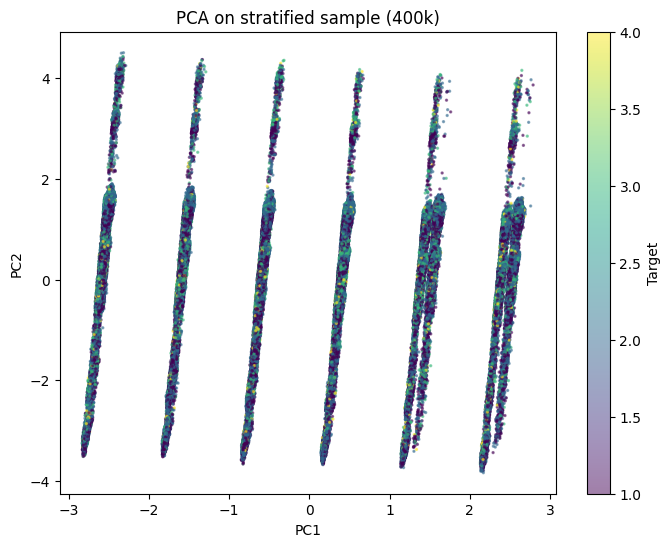

In [82]:
# PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_sample_piped)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_sample_piped, cmap='viridis', alpha=0.5, s=2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on stratified sample (400k)")
plt.colorbar(label="Target")
plt.show()

In [46]:
print(pca.explained_variance_ratio_)
# PC1 17,6 %, PC2 12,8% and PC3 7,5%. 
# that shows that our data are high dimensional. there is no dominant component
# also the plot shows that the classes are not well separated in the first two principal components.
# the color is mixed and there is not a clear cluster separation between the classes.


[0.17614613 0.12841923 0.07535061]


In [83]:
# UMAP
X_sub = X_sample_piped[:5000]
y_sub = y_sample_piped[:5000]
X_umap = umap.UMAP(n_components=2,
                   random_state=42).fit_transform(X_sub)




/opt/homebrew/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


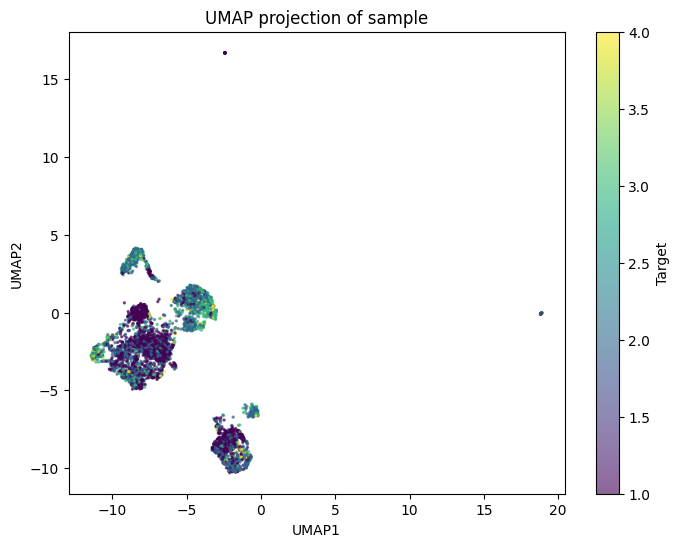

In [84]:
# plot UMAP
plt.figure(figsize=(8,6))
plt.scatter(
    X_umap[:,0],
    X_umap[:,1],
    c=y_sub,  
    cmap="viridis",
    s=2,
    alpha=0.6
)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP projection of sample")
plt.colorbar(label="Target")
plt.show()

- UMAP also shows that colors are overlapping but also shows 2 or 3 clusters. 
- the target class 4 overlaps with the other target classes. 

In [85]:
# XGBoost for  Analysis
y_sample_encoded = np.array(y_sample_piped) - 1  # XGBoost requires labels starting from 0
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_sample_piped, y_sample_encoded)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [86]:
names = preprocessing_pipeline.named_steps['encode_scale'].get_feature_names_out()
len(names), names[:5]
X_sample_df = pd.DataFrame(X_sample_piped, columns=names)
X_sample_df.shape, X_sample_df.columns[:5]
X_sample_df=X_sample_df.astype('float')

In [87]:
print(type(X_sample_piped[0,0]))

<class 'float'>


In [53]:
import shap
print(shap.__version__)
print(names[:10])
print(len(names), X_sample_piped.shape[1])


0.49.1
['spline_hour__acc_hour_sp_0' 'spline_hour__acc_hour_sp_1'
 'spline_hour__acc_hour_sp_2' 'spline_hour__acc_hour_sp_3'
 'spline_hour__acc_hour_sp_4' 'spline_month__acc_month_sp_0'
 'spline_month__acc_month_sp_1' 'spline_month__acc_month_sp_2'
 'onehot__acc_ambient_lightning_1.0' 'onehot__acc_ambient_lightning_2.0']
155 155


In [88]:
#XGBoost Gain
booster = xgb_model.get_booster()
importance = booster.get_score(importance_type="gain")

# Map f0, f1, ... to actual names
importance_named = {names[int(k[1:])]: v for k, v in importance.items()}

importance_df = pd.DataFrame({
    "feature": list(importance_named.keys()),
    "importance": list(importance_named.values())
}).sort_values("importance", ascending=False)

print(importance_df.head(20))
print(importance_df.tail(50))



                              feature  importance
64              onehot__ind_secu1_1.0  555.351990
90      onehot__veh_moving_obstacle_1  245.913116
68              onehot__ind_secu1_8.0  197.150894
13   onehot__acc_urbanization_level_1  187.622238
80       onehot__veh_fixed_obstacle_0  171.297699
54                  onehot__ind_sex_2  130.886459
50                  onehot__ind_cat_1  130.819336
133  remainder__loca_traffic_circul_2  110.367882
65              onehot__ind_secu1_2.0  108.492645
49               onehot__ind_place_10   99.500801
109         onehot__veh_maneuver_15.0   86.995758
66              onehot__ind_secu1_3.0   81.592682
89      onehot__veh_moving_obstacle_0   77.183449
52                  onehot__ind_cat_3   75.409042
14   onehot__acc_urbanization_level_2   71.452713
72                  onehot__veh_cat_7   71.368507
76                 onehot__veh_cat_33   67.116837
148        remainder__loca_accident_3   63.033527
60                 onehot__ind_trip_4   59.439384


interpretation of gain performance:
- Gain Perfromance shows how strong the feature improves the loss function, when it is included in a split
- it shows that the model prefers these features. but its not given that it really helps to really improve performance
- 

In [73]:
print(X_sample.columns)
df.acc_municipality.unique() # reduce cardinality

df.veh_cat.unique() # reduce cardinality?
# acc_year, ind_year, acc_date, acc_hour do we have to keep them all?




Index(['acc_num', 'ind_place', 'ind_cat', 'ind_sex', 'ind_trip', 'ind_secu1',
       'ind_secu2', 'ind_location', 'ind_action', 'ind_year', 'ind_age',
       'ind_age_group', 'ind_temp_id', 'acc_date', 'acc_year', 'acc_month',
       'acc_hour', 'acc_department', 'acc_municipality', 'acc_metro',
       'acc_long', 'acc_lat', 'acc_ambient_lightning', 'acc_atmosphere',
       'acc_urbanization_level', 'acc_intersection', 'acc_collision_type',
       'veh_cat', 'veh_fixed_obstacle', 'veh_moving_obstacle', 'veh_impact',
       'veh_maneuver', 'veh_motor', 'veh_id', 'loca_road_cat',
       'loca_traffic_circul', 'loca_road_lanes', 'loca_road_gradient',
       'loca_road_view', 'loca_road_surface_cond', 'loca_accident',
       'loca_max_speed', 'loca_is_intersection'],
      dtype='object')


array([ 7, 17, 33, 42, 30, 37, 32, 50, 38, 10,  1, 40, 15, 14, 99,  2, 80,
       34, 60, 31,  0, 21,  3, 13, 20, 43, 36, 39, 16, 35, 41])

# !! Permuation_importance without max_samples parameter run over 80 minutes. so i added this parameter for later runs.but the results below are based on the 80 minutes run. 

In [ ]:
from sklearn.inspection import permutation_importance

# compute permutation importance
result = permutation_importance(
    xgb_model,
    X_sample_piped,
    y_sample_encoded,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
    max_samples=10000
)

# results in DataFrame
perm_df = pd.DataFrame({
    "feature": preprocessing_pipeline.get_feature_names_out(),
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

print(perm_df.head(20))


Python(8479) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8480) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8481) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8482) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8483) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8484) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8485) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8486) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


AttributeError: Estimator remove_cols does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?

# careful before max_samples this code run 85 minutes. 

In [91]:
ct = preprocessing_pipeline.named_steps["encode_scale"]

perm_df = pd.DataFrame({
    "feature": ct.get_feature_names_out(),
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

print(perm_df.head(20))
print(perm_df.tail(50))

                              feature  importance_mean  importance_std
65              onehot__ind_secu1_1.0         0.056957        0.000254
49               onehot__ind_place_10         0.037983        0.000147
91      onehot__veh_moving_obstacle_1         0.027051        0.000213
81       onehot__veh_fixed_obstacle_0         0.018539        0.000292
124        catboost__acc_municipality         0.010497        0.000195
55                  onehot__ind_sex_2         0.009569        0.000587
73                  onehot__veh_cat_7         0.008407        0.000171
77                 onehot__veh_cat_33         0.007266        0.000261
127          remainder__ind_age_group         0.007105        0.000115
69              onehot__ind_secu1_8.0         0.006906        0.000075
13   onehot__acc_urbanization_level_1         0.005275        0.000404
50                  onehot__ind_cat_1         0.004557        0.000126
126             scale__loca_max_speed         0.004546        0.000091
72    

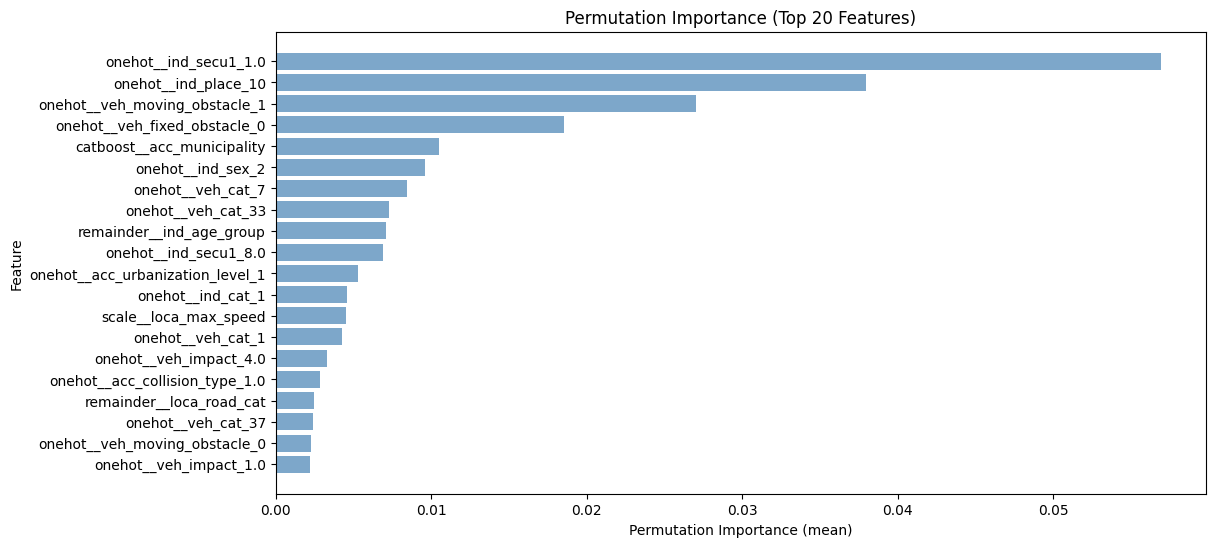

In [92]:
# plot permutation importance Top 20
top_features = perm_df.sort_values("importance_mean", ascending=False).head(20)

plt.figure(figsize=(12,6))
plt.barh(top_features["feature"], top_features["importance_mean"], color="steelblue", alpha=0.7)
plt.xlabel("Permutation Importance (mean)")
plt.ylabel("Feature")
plt.title("Permutation Importance (Top 20 Features)")
plt.gca().invert_yaxis()  # höchste Werte oben
plt.show()

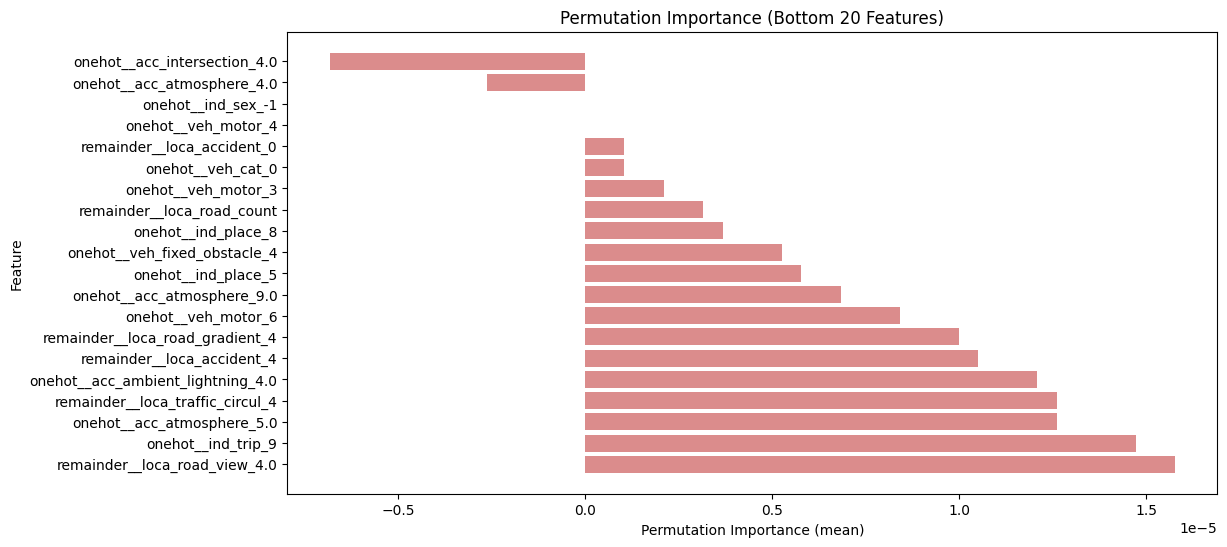

In [93]:
# plot permutation importance Bottom 20
bottom_features = perm_df.sort_values("importance_mean", ascending=True).head(20)

plt.figure(figsize=(12,6))
plt.barh(bottom_features["feature"], bottom_features["importance_mean"], color="indianred", alpha=0.7)
plt.xlabel("Permutation Importance (mean)")
plt.ylabel("Feature")
plt.title("Permutation Importance (Bottom 20 Features)")
plt.gca().invert_yaxis()
plt.show()


In [98]:
display(X_sample["acc_atmosphere"].value_counts())
X_sample["acc_intersection"].value_counts()


acc_atmosphere
1.0    313983
2.0     45501
8.0     16348
3.0      9360
7.0      7474
5.0      2945
9.0      1734
4.0      1499
6.0      1135
Name: count, dtype: int64

acc_intersection
1.0    230176
2.0     63988
3.0     54413
6.0     17084
9.0     15931
4.0     10422
7.0      4110
5.0      2902
8.0       958
Name: count, dtype: int64

interpreation of permutation importance:
- Safety equipment (ind_secu1), accident place categories, and obstacle variables show the strongest impact on predictions.
- Many atmosphere dummies, intersection categories, and specific vehicle motor codes show near‑zero importance, indicating little added value.
- Overall t